# Getting started

In [49]:
### Load packages
library(data.table)
library(readxl)
library(stringr)
library(dplyr)
library(forecast)
library(ggplot2)
library(tseries)
library(stats)
library(psych)
library(fUnitRoots)
library(lmtest)
library(pastecs)
library(FitAR)
library(aTSA)
library(itsmr)
library(pracma)
library(arfima)
library(dse)
library(smooth)
library(fGarch)

In [50]:
list.files(pattern = ".csv")

[1] "^BSESN.csv"    "^GSPC.csv"     "^HSI.csv"      "^JKSE.csv"    
 [5] "^MERV.csv"     "^N225.csv"     "^NSEI.csv"     "^NZ50.csv"    
 [9] "^STOXX50E.csv" "000001.SS.csv"

# Portfolio
An equally weighted portfolio is formed with HSI and NZ50, and we can see if there exists any commonly shared information between the two stocks, such that we can do nonsynchronous trading.
## Portfolio – Data Exploration

In [51]:
# Load data

df1 = read.csv('^HSI.csv')
df1 %>% setDT
df1 = df1[,.(date = as.Date(Date),
                 Price = Adj.Close%>% as.character %>% as.numeric)]
df1 = df1[date>='2019-05-04' & date <= '2020-05-08',]
df1 = na.omit(df1)
setkey(df1, date)
df1 %>% tail

Warning message in function_list[[k]](value):
"NAs introduced by coercion"


date,Price
<date>,<dbl>
2020-04-29,24643.59
2020-05-04,23613.80
2020-05-05,23868.66
2020-05-06,24137.48
2020-05-07,23980.63
2020-05-08,24230.17


In [52]:
# Load data

df2 = read.csv('^NZ50.csv')
df2 %>% setDT
df2 = df2[,.(date = as.Date(Date),
                 Price = Adj.Close%>% as.character %>% as.numeric)]
df2 = df2[date>='2019-05-04' & date <= '2020-05-08',]
df2 = na.omit(df2)
setkey(df2, date)
df2 %>% tail

Warning message in function_list[[k]](value):
"NAs introduced by coercion"


date,Price
<date>,<dbl>
2020-05-01,10449.01
2020-05-04,10516.09
2020-05-05,10551.16
2020-05-06,10596.77
2020-05-07,10676.25
2020-05-08,10695.59


In [53]:
df = merge(df1, df2, all=FALSE, by = 'date')
df[, Price := 0.5*Price.x + 0.5*Price.y]
df %>% tail

date,Price.x,Price.y,Price
<date>,<dbl>,<dbl>,<dbl>
2020-04-29,24643.59,10725.15,17684.37
2020-05-04,23613.80,10516.09,17064.95
2020-05-05,23868.66,10551.16,17209.91
2020-05-06,24137.48,10596.77,17367.12
2020-05-07,23980.63,10676.25,17328.44
2020-05-08,24230.17,10695.59,17462.88


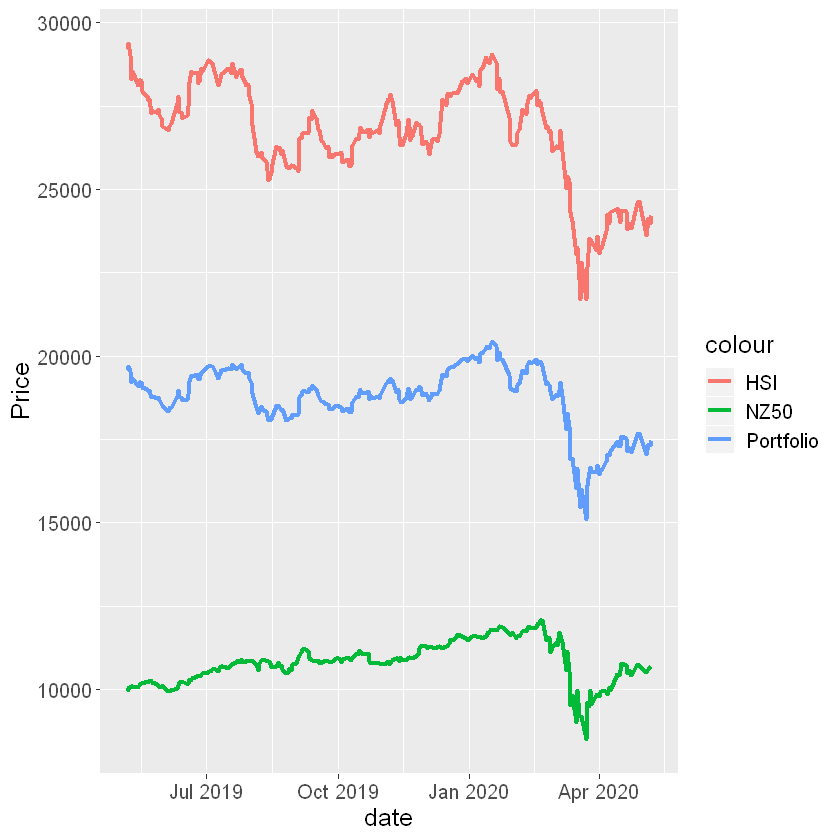

In [55]:
# Graph of the index

ggplot(df, aes(x=date)) + geom_line(aes(y=Price,color="Portfolio"),lwd=1.2)+
    geom_line(aes(y=Price.x,color="HSI"),lwd=1.2) +
     geom_line(aes(y=Price.y,color="NZ50"),lwd=1.2)  +
  theme(text = element_text(size=15)) +
  scale_size_manual( values = c(4,2,2) )

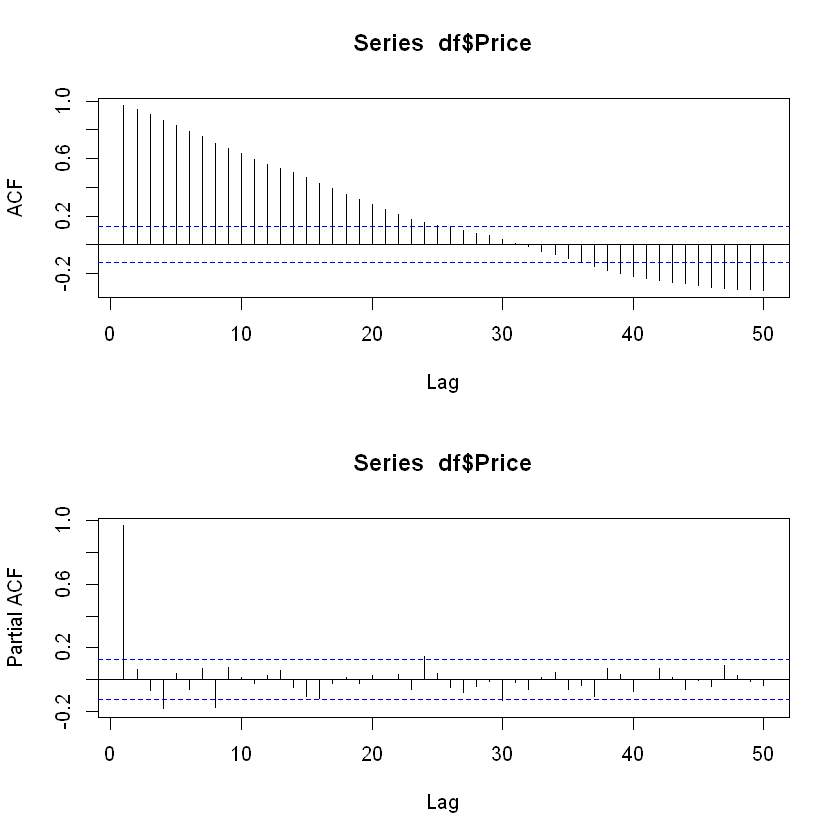

In [56]:
# ACFs and PACFs 
par(mfrow=c(2,1))

Acf(df$Price, lag.max = 50)

Pacf(df$Price, lag.max = 50)

In [57]:
# Augmented Dickey-Fuller Test

aTSA::adf.test(df$Price, nlag = NULL, output = TRUE)

Augmented Dickey-Fuller Test 
alternative: stationary 
 
Type 1: no drift no trend 
     lag    ADF p.value
[1,]   0 -0.671   0.439
[2,]   1 -0.768   0.404
[3,]   2 -0.682   0.435
[4,]   3 -0.474   0.508
[5,]   4 -0.535   0.488
Type 2: with drift no trend 
     lag   ADF p.value
[1,]   0 -1.74   0.431
[2,]   1 -1.54   0.507
[3,]   2 -1.65   0.464
[4,]   3 -2.06   0.303
[5,]   4 -1.90   0.369
Type 3: with drift and trend 
     lag   ADF p.value
[1,]   0 -1.98   0.585
[2,]   1 -1.75   0.681
[3,]   2 -1.89   0.622
[4,]   3 -2.38   0.416
[5,]   4 -2.19   0.495
---- 
Note: in fact, p.value = 0.01 means p.value <= 0.01 


From the graph and ACF plot, we can see the persistence of the price is very high. It brings the question whether it is nonstationary. Checking with Augmented Dickey-Fuller test, the p-values are all greater than 0.05, meaning we fail to reject the null hypothesis that the time series is non-stationary and unit root exists. So, we need to use log differences to make it mean stationary:
$R_t = log(P_t) - log(P_{t-1})$

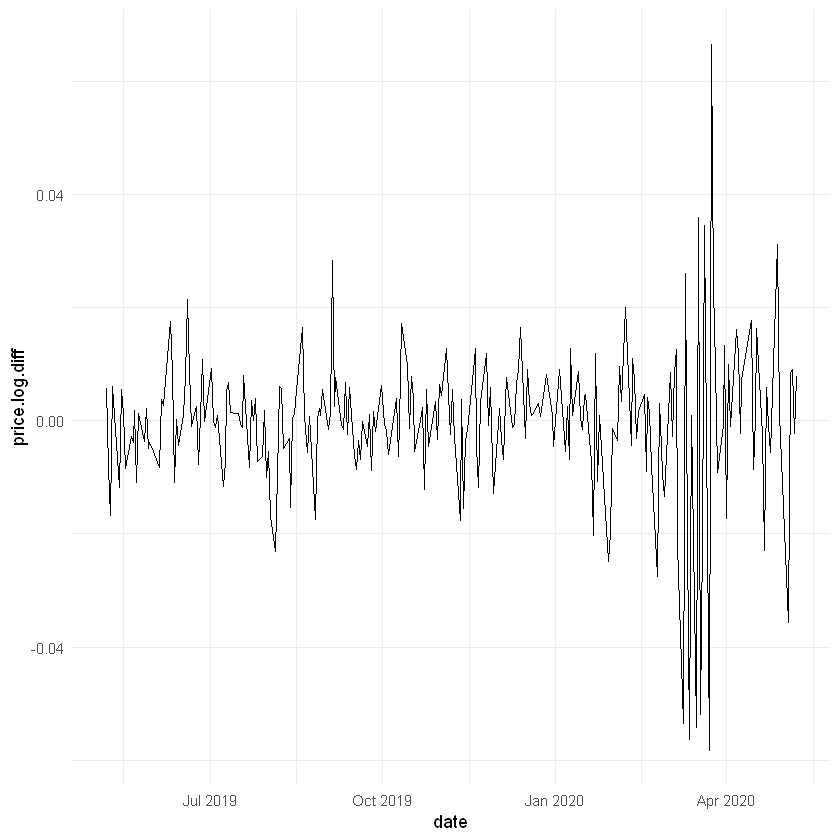

In [58]:
df[, price.lag.1:= shift(Price, type = 'lag', n=1) ]
df[, price.log.diff := log(Price) - log(price.lag.1)]
df = na.omit(df)
ggplot(df, aes(x=date)) + geom_line(aes(y=price.log.diff,group=1))+ theme_minimal() 

In [59]:
# Descriptive statistics 

stat.desc(df$price.log.diff)

nbr.val      nbr.null        nbr.na           min           max 
 2.450000e+02  0.000000e+00  0.000000e+00 -5.822136e-02  6.647464e-02 
        range           sum        median          mean       SE.mean 
 1.246960e-01 -1.146977e-01  6.670551e-04 -4.681540e-04  8.505665e-04 
 CI.mean.0.95           var       std.dev      coef.var 
 1.675390e-03  1.772485e-04  1.331347e-02 -2.843823e+01

In [60]:
getmode <- function(v) {
   uniqv <- unique(v)
   uniqv[which.max(tabulate(match(v, uniqv)))]
}
getmode(df$price.log.diff)

[1] 0.005599973

In [61]:
kurtosis(df$price.log.diff)

[1] 6.865558
attr(,"method")
[1] "excess"

In [62]:
skewness(df$price.log.diff)

[1] -0.7397374
attr(,"method")
[1] "moment"

, , 1

               [,1]
 [1,]  1.0000000000
 [2,] -0.1576422302
 [3,]  0.0950022737
 [4,]  0.1883801471
 [5,] -0.1412096205
 [6,]  0.1834291501
 [7,] -0.1350969432
 [8,]  0.1298873478
 [9,] -0.1019521094
[10,] -0.0528312722
[11,]  0.0750591288
[12,] -0.1036295666
[13,] -0.0131925228
[14,] -0.0273727216
[15,]  0.0739409968
[16,]  0.0691733981
[17,] -0.0318283722
[18,] -0.0066905155
[19,] -0.0039370782
[20,] -0.0695757636
[21,] -0.0372495280
[22,] -0.0499862480
[23,] -0.0044756521
[24,] -0.1652666448
[25,] -0.0654638587
[26,]  0.0397484898
[27,] -0.0565412842
[28,]  0.0327786312
[29,] -0.0579149835
[30,]  0.0120377848
[31,]  0.0313024985
[32,] -0.0044620404
[33,]  0.0712226861
[34,] -0.0477548432
[35,]  0.0459284177
[36,]  0.0509472816
[37,]  0.0749020180
[38,] -0.0576187630
[39,] -0.0468613541
[40,]  0.0310820364
[41,] -0.0673254012
[42,]  0.0179438980
[43,] -0.0296056898
[44,] -0.0005432183
[45,] -0.0301196588
[46,]  0.0096401292
[47,] -0.0291934248
[48,] -0.0684546622
[49,] -0.0055636087
[50,]  0.0127937894
[51,]  0.0122457300

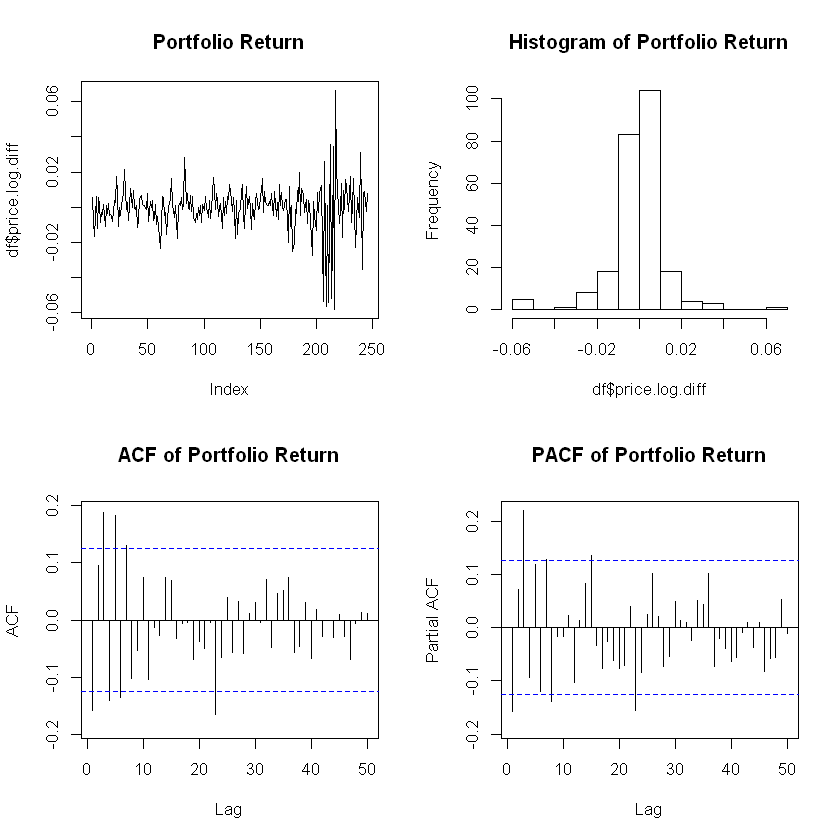

In [65]:
# ACFs and PACFs 
par(mfrow=c(2,2))
plot(df$price.log.diff, type="l", main = "Portfolio Return")
hist(df$price.log.diff, main = "Histogram of Portfolio Return")

acf = Acf(df$price.log.diff, lag.max = 50, main = "ACF of Portfolio Return")
acf$acf
Pacf(df$price.log.diff, lag.max = 50, main = "PACF of Portfolio Return")

### Time series sharing common information:
Finding $\gamma_1^{ij} = Cov(R_t^{NZ50}, R_{t-1}^{HSI})$
Let i be NZ50, j be HSI,
$\gamma_1 = Cov(R_t, R_{t-1}) = Cov(\frac{R_t^i+R_t^j}{2}, \frac{R_{t-1}^i+R_{t-1}^j}{2})=\frac{1}{4} [\gamma_1^i + \gamma_1^j + \gamma_1^{ij} + \gamma_1^{ji}] = -0.15764$
Note that $\gamma_1^j = 0$ as HSI return is white noise; $\gamma_1^{ji}$ is assumed to be zero since there is no common news between the two returns;  $\gamma_1^i = -0.41202$; Therefore, $\gamma_1^{ij} = -0.41202$. 
$95\% Confidence Interval = [\pm \frac{1.96}{\sqrt{245}}] = [-0.1252, 0.1252]$
Therefore, $\gamma_1^{ij}$ is statistically significant, thus nonsynchronous trading is possible. 

In [66]:
# Augmented Dickey-Fuller Test

aTSA::adf.test(df$price.log.diff, nlag = NULL, output = TRUE)

Augmented Dickey-Fuller Test 
alternative: stationary 
 
Type 1: no drift no trend 
     lag    ADF p.value
[1,]   0 -18.24    0.01
[2,]   1 -10.96    0.01
[3,]   2  -7.14    0.01
[4,]   3  -7.06    0.01
[5,]   4  -5.68    0.01
Type 2: with drift no trend 
     lag    ADF p.value
[1,]   0 -18.23    0.01
[2,]   1 -10.96    0.01
[3,]   2  -7.14    0.01
[4,]   3  -7.06    0.01
[5,]   4  -5.68    0.01
Type 3: with drift and trend 
     lag    ADF p.value
[1,]   0 -18.20    0.01
[2,]   1 -10.94    0.01
[3,]   2  -7.13    0.01
[4,]   3  -7.06    0.01
[5,]   4  -5.68    0.01
---- 
Note: in fact, p.value = 0.01 means p.value <= 0.01 


In [67]:
#  Ljung-Box Test
Box.test(df$price.log.diff, lag = 50, type = "Ljung-Box")


	Box-Ljung test

data:  df$price.log.diff
X-squared = 75.097, df = 50, p-value = 0.01236


The return is seems mean stationary, however, is obviously variance non-stationary from the plot. From the Augmented Dickey-Fuller test, the coefficients are all negative in the three types of test, and the p-value is smaller than 0.01, indicating the data do not have unit root and is covariance stationary. From the ACF graph, it has spikes on the first few lags, and then a decay toward zero; PACF shows splike from first lag and a smooth decay toward zero. These are signs that the time zeries may be an ARMA process.

## Model Selection

In [68]:
# prepare ts data

df.ts = df[ date < '2020-05-04', list(date, price.log.diff)] 
tsdata = ts(df.ts$price.log.diff, start = df$date[1], frequency = 365)
print(paste("Number of observations:",length(tsdata)))

[1] "Number of observations: 240"


In [69]:
#  fitting different ARMA models and compare with AIC

auto.arima(tsdata, trace=TRUE)


 Fitting models using approximations to speed things up...

 ARIMA(2,0,2)             with non-zero mean : -1400.247
 ARIMA(0,0,0)             with non-zero mean : -1392.358
 ARIMA(1,0,0)             with non-zero mean : -1395.413
 ARIMA(0,0,1)             with non-zero mean : -1394.889
 ARIMA(0,0,0)             with zero mean     : -1394.143
 ARIMA(1,0,2)             with non-zero mean : -1401.451
 ARIMA(0,0,2)             with non-zero mean : -1402.558
 ARIMA(0,0,3)             with non-zero mean : -1404.067
 ARIMA(1,0,3)             with non-zero mean : -1414.939
 ARIMA(2,0,3)             with non-zero mean : -1412.123
 ARIMA(1,0,4)             with non-zero mean : -1413.394
 ARIMA(0,0,4)             with non-zero mean : -1407.295
 ARIMA(2,0,4)             with non-zero mean : Inf
 ARIMA(1,0,3)             with zero mean     : -1416.878
 ARIMA(0,0,3)             with zero mean     : -1405.975
 ARIMA(1,0,2)             with zero mean     : -1403.339
 ARIMA(2,0,3)             with ze

Series: tsdata 
ARIMA(1,0,3) with zero mean 

Coefficients:
          ar1     ma1     ma2     ma3
      -0.6371  0.5523  0.0363  0.2977
s.e.   0.0932  0.1002  0.0729  0.0589

sigma^2 estimated as 0.0001547:  log likelihood=714.13
AIC=-1418.26   AICc=-1418   BIC=-1400.85

Using AIC as model selection criterion, the best model estimated is ARMA(1,3)

#### ARMA(1,3)
$R_t=\delta+\varphi_1R_{t-1}+\varepsilon_t+\theta_1\varepsilon_{t-1}+\theta_2\varepsilon_{t-2}+\theta_3\varepsilon_{t-3}$

In [17]:
fitARIMA <- arima(tsdata, order=c(1,0,3),method="ML")
coeftest(fitARIMA)


z test of coefficients:

             Estimate  Std. Error z value  Pr(>|z|)    
ar1       -0.63739625  0.09315677 -6.8422 7.799e-12 ***
ma1        0.55189381  0.10011798  5.5124 3.539e-08 ***
ma2        0.03498287  0.07293616  0.4796    0.6315    
ma3        0.29691070  0.05895942  5.0358 4.757e-07 ***
intercept -0.00040842  0.00091637 -0.4457    0.6558    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


Although ARMA(1,3) has the lowest AIC. From the plot, all roots of characteristic polynomial lie inside unit circle and thus it is stationary and invertible. However, not all its coefficients are statistically significant. Therefore, we would take a look at other models with comparable AIC.

#### ARMA(1,2)

In [24]:
fitARIMA <- arima(tsdata, order=c(1,0,2),method="ML")
coeftest(fitARIMA)


z test of coefficients:

             Estimate  Std. Error z value Pr(>|z|)    
ar1        0.38188252  0.25030095  1.5257  0.12709    
ma1       -0.54795404  0.24110074 -2.2727  0.02304 *  
ma2        0.26820150  0.06396022  4.1933 2.75e-05 ***
intercept -0.00039637  0.00095853 -0.4135  0.67923    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


#### ARMA(0,2)
$R_t=\delta+\varepsilon_t+\theta_1\varepsilon_{t-1}+\theta_2\varepsilon_{t-2}$

In [25]:
fitARIMA <- arima(tsdata, order=c(0,0,2),method="ML")
coeftest(fitARIMA)


z test of coefficients:

             Estimate  Std. Error z value Pr(>|z|)    
ma1       -0.18789584  0.06421678 -2.9260 0.003434 ** 
ma2        0.22249976  0.06712252  3.3148 0.000917 ***
intercept -0.00040688  0.00085655 -0.4750 0.634774    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


In [26]:
fitARIMA <- arima(tsdata, order=c(0,0,2),method="ML", include.mean = FALSE)
coeftest(fitARIMA)


z test of coefficients:

     Estimate Std. Error z value  Pr(>|z|)    
ma1 -0.187156   0.064220 -2.9143 0.0035651 ** 
ma2  0.223368   0.067029  3.3324 0.0008609 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


All coefficients are statistically significant.

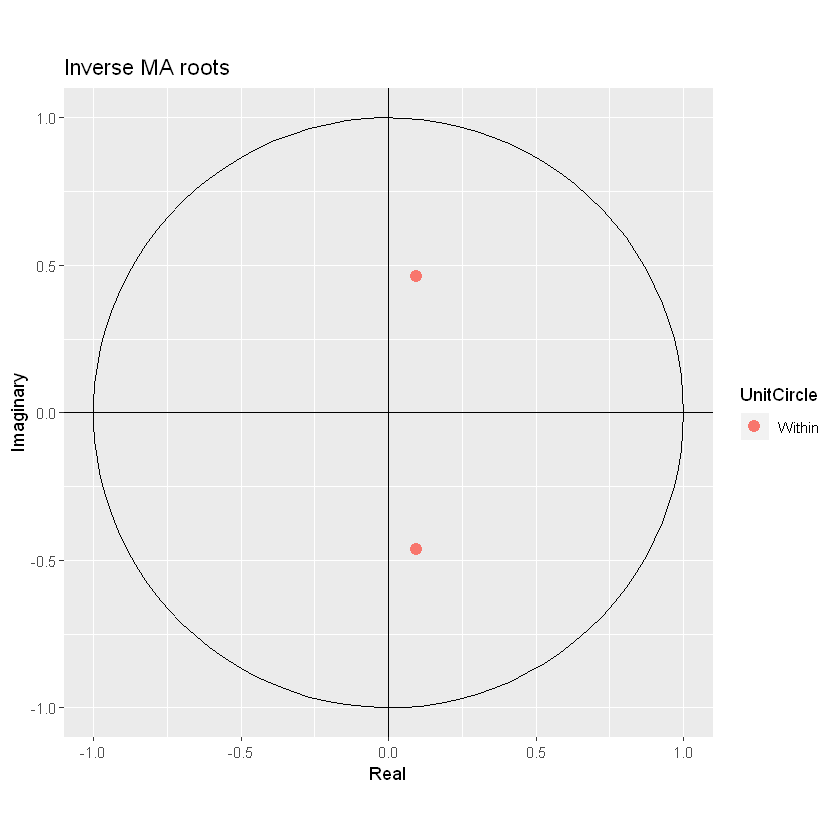

In [27]:
# Inverse characteristic roots

autoplot(fitARIMA)

All roots lie inside unit circle, showing the model is stationary and invertible.


	Ljung-Box test

data:  Residuals from ARIMA(0,0,2) with zero mean
Q* = 49.984, df = 46, p-value = 0.3181

Model df: 2.   Total lags used: 48



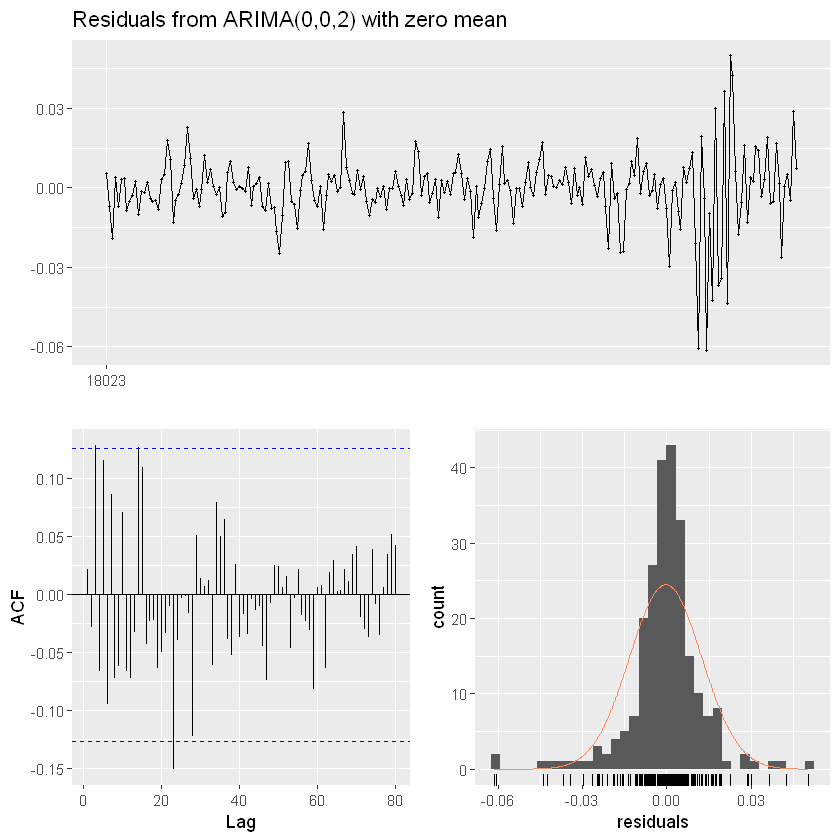

In [28]:
checkresiduals(fitARIMA)

Since p-value > 0.05, we fail to reject the null hypothesis that all autocorrelations up to order 50 are equal to zero, meaning the residuals are independent at 95% level. Thus, ARMA(0,2) is a good fit as the residuals are seemingly white noise. However, it is obvious from the plot that the residuals have time-varying volatility.

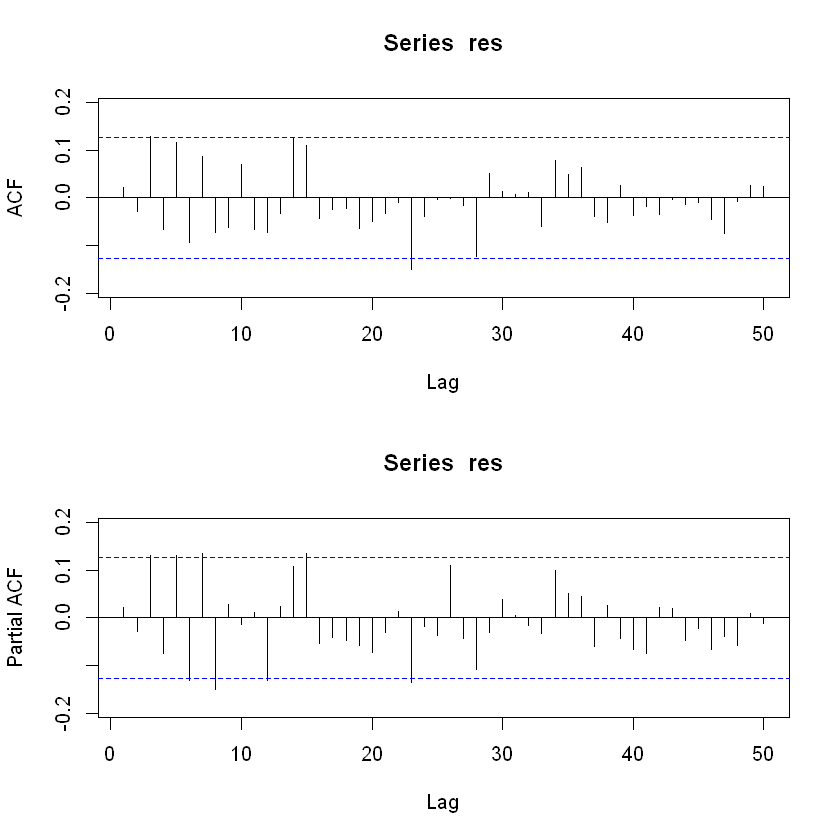

In [29]:
res = residuals(fitARIMA)
# ACFs and PACFs  of residuals 
par(mfrow=c(2,1))

Acf(res, lag.max = 50)

Pacf(res, lag.max = 50)

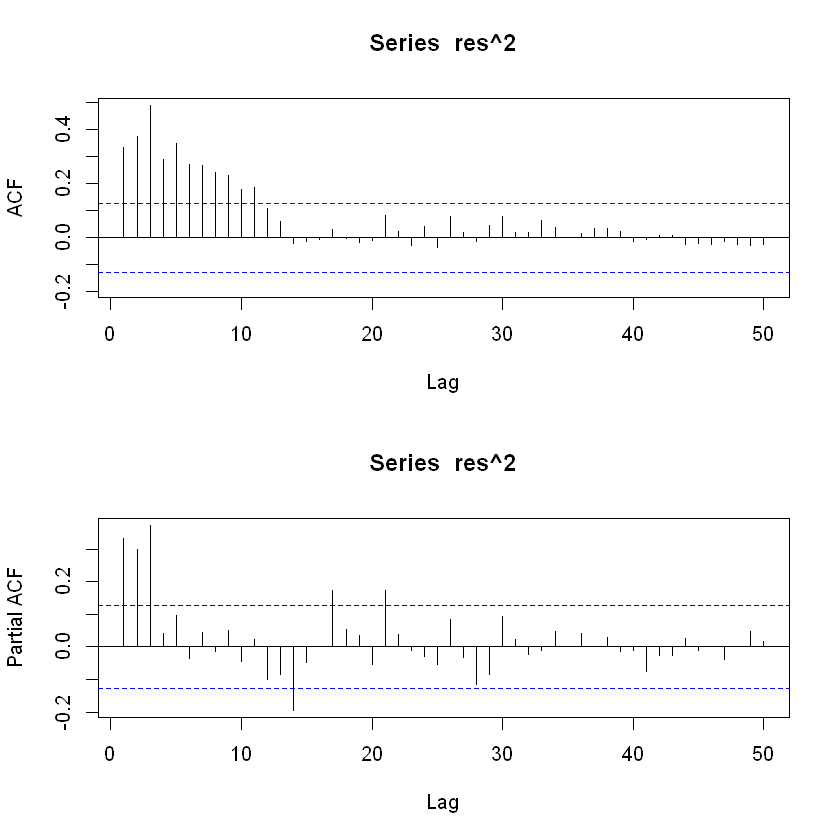

In [30]:
res = residuals(fitARIMA)
# ACFs and PACFs  of residuals 
par(mfrow=c(2,1))

Acf(res^2, lag.max = 50)

Pacf(res^2, lag.max = 50)

From the ACF and PACF plot of squared residuals, we can see the residuals exhibit time-varying volatility as it has autocorrelations with high persistence form the ACF plot with some spikes. Therefore, we would use GARCH model to predict the volatility.

## Forecast with rolling scheme

#### Forecast for May 4:

In [31]:
df.ts = df[ date < '2020-05-04', list(date, price.log.diff)]
tsdata = ts(df.ts$price.log.diff, start = df$date[1], frequency = 365)
fitARIMA <- arima(tsdata, order=c(0,0,2),method="ML", include.mean = FALSE)
# fitARIMA <- arima(tsdata, order=c(3,0,1),method="ML", include.mean = TRUE)
predict(fitARIMA, n.ahead=1)

$pred
Time Series:
Start = c(18023, 241) 
End = c(18023, 241) 
Frequency = 365 
[1] 0.005077457

$se
Time Series:
Start = c(18023, 241) 
End = c(18023, 241) 
Frequency = 365 
[1] 0.01280795

In [32]:
coef(fitARIMA)

ma1        ma2 
-0.1871560  0.2233677

In [33]:
# Manual calculation of one-step ahead forecast for May 4:
# ar1 = coef(fitARIMA)['ar1']
# ar2 = coef(fitARIMA)['ar2']
# ar3 = coef(fitARIMA)['ar3']
ma1 = coef(fitARIMA)['ma1']
ma2 = coef(fitARIMA)['ma2']
mu = coef(fitARIMA)['intercept']
# y.series = df.ts$price.log.diff
# y.t = y.series[length(y.series)-0]
# y.t.1 = y.series[length(y.series)-1]
# y.t.2 = y.series[length(y.series)-2]
res = residuals(fitARIMA)
eps.t = res[length(res)-0]
eps.t.1 = res[length(res)-1]
f.1 = ma1 * eps.t + ma2 * eps.t.1
f.1.4 = f.1
print(paste("The one-step ahead forecast is: ",f.1))

[1] "The one-step ahead forecast is:  0.0050774568676682"


In [34]:
y.truth = df[date == "2020-05-04", list(date, price.log.diff)]$price.log.diff
y.4 = y.truth
print(paste("The truth value is: ",y.truth))
eps.t.update = y.truth - f.1
e.4 = eps.t.update
print(paste("The forecast error is:", eps.t.update))

[1] "The truth value is:  -0.035654827562654"
[1] "The forecast error is: -0.0407322844303222"



Call:
garch(x = y, order = c(1, 1), trace = FALSE)

Model:
GARCH(1,1)

Residuals:
     Min       1Q   Median       3Q      Max 
-4.36909 -0.53389  0.03172  0.51432  3.73334 

Coefficient(s):
    Estimate  Std. Error  t value Pr(>|t|)    
a0 1.466e-05   6.190e-06    2.368   0.0179 *  
a1 2.092e-01   4.404e-02    4.749 2.04e-06 ***
b1 6.880e-01   8.610e-02    7.991 1.33e-15 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Diagnostic Tests:
	Jarque Bera Test

data:  Residuals
X-squared = 67.573, df = 2, p-value = 2.109e-15


	Box-Ljung test

data:  Squared.Residuals
X-squared = 0.00079924, df = 1, p-value = 0.9774


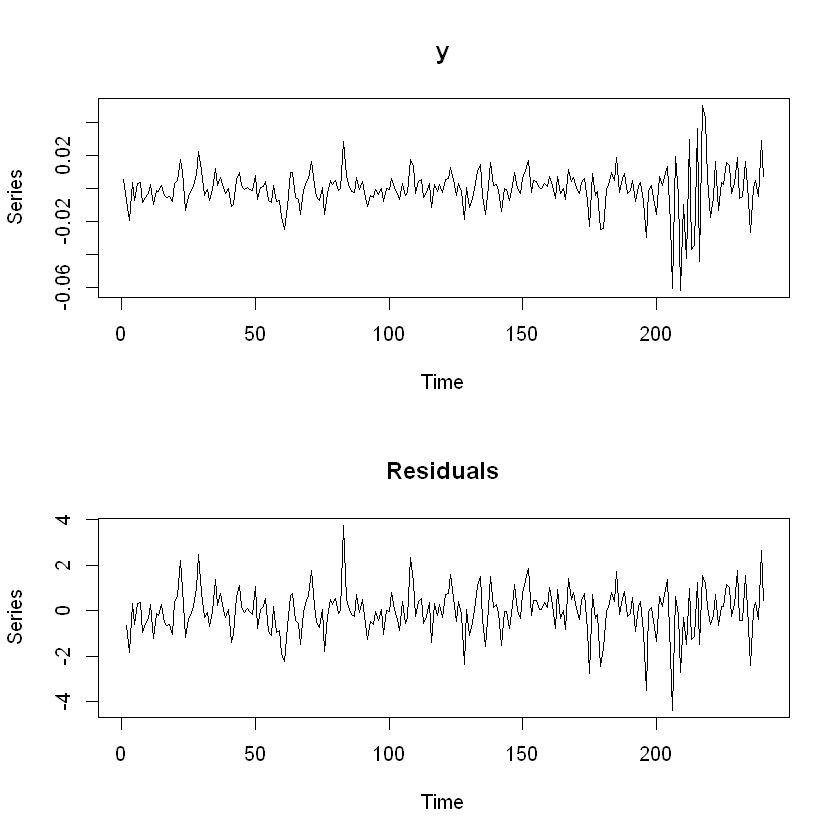

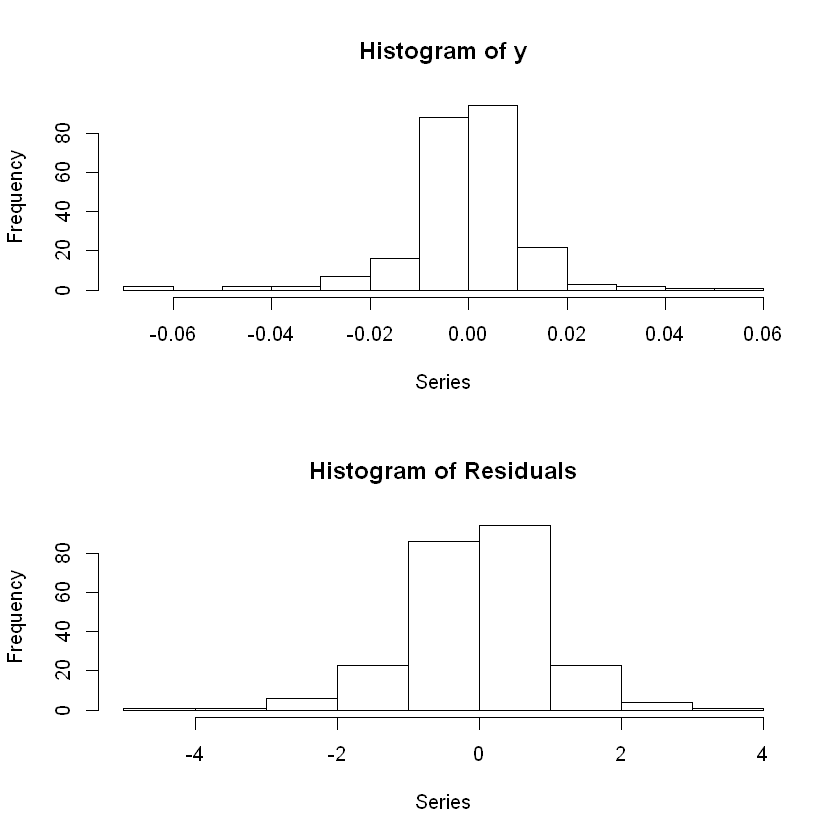

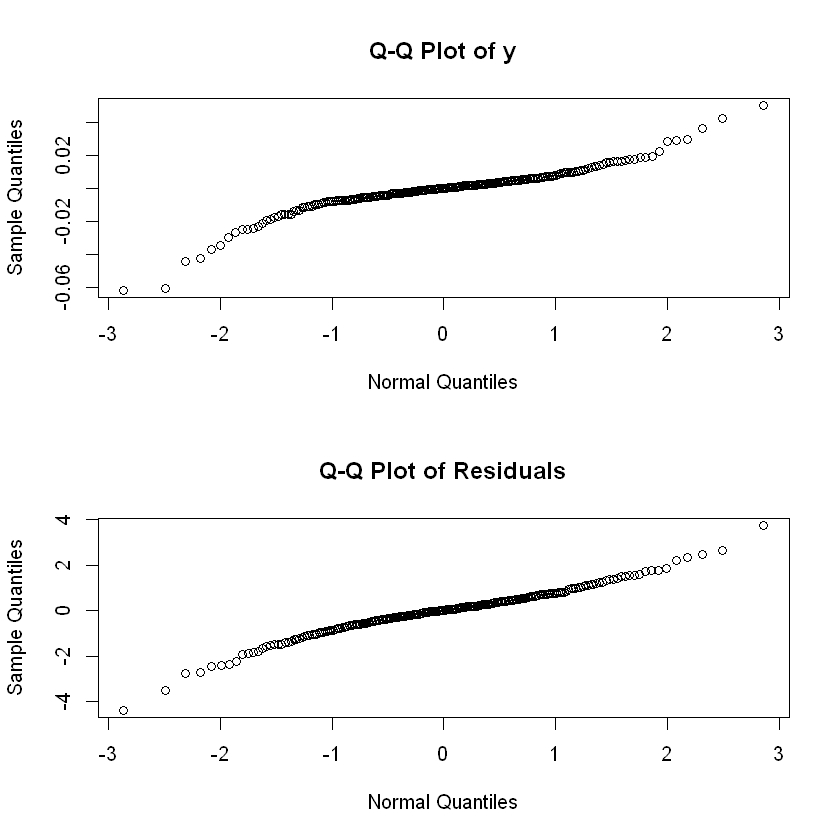

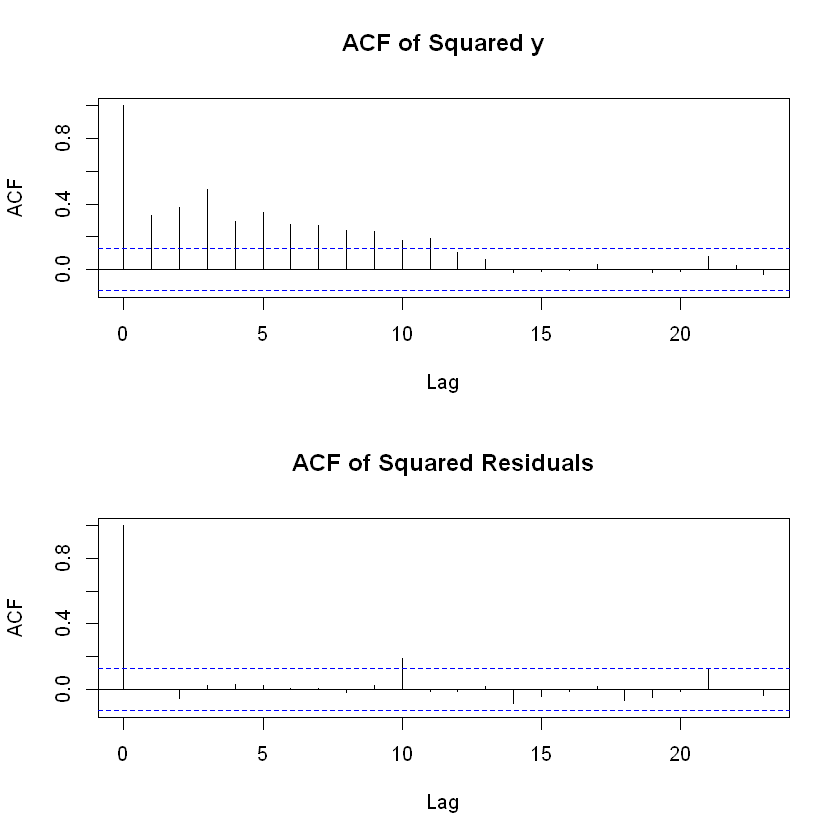

In [35]:
y <- ts(res)
garch.y <- garch(y, order = c(1,1), trace=FALSE)  # Fit GARCH(1,1)
summary(garch.y)                     # Diagnostic tests

plot(garch.y)

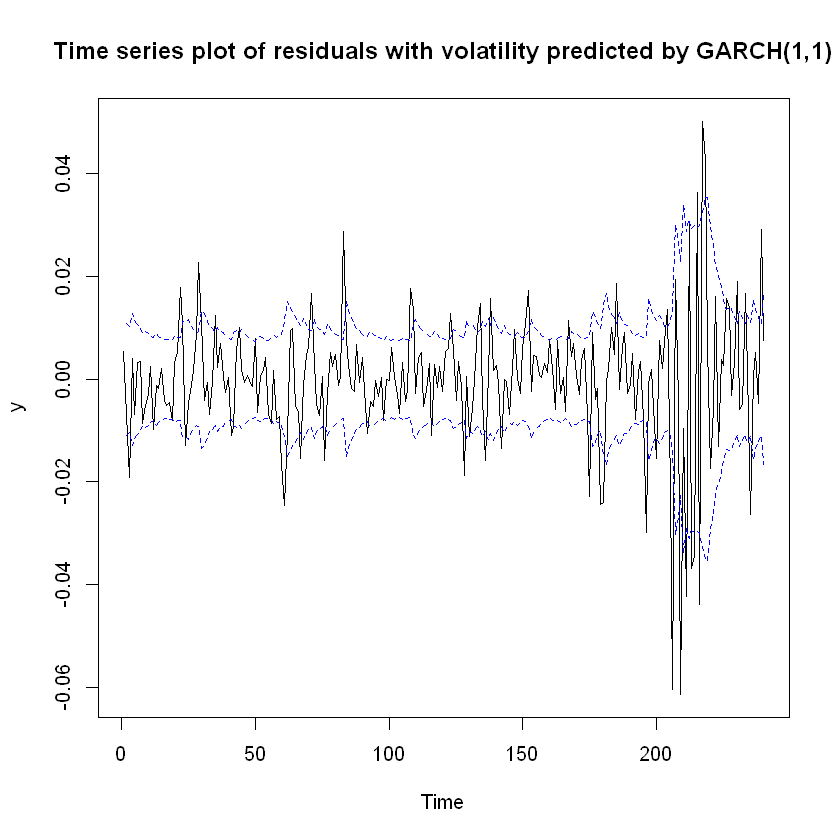

In [36]:
u = predict(garch.y)
u = u %>% na.omit
plot(y, type="l", xlab="Time", main = "Time series plot of residuals with volatility predicted by GARCH(1,1)")
lines(u[,1], col="blue", lty="dashed")
lines(u[,2], col="blue", lty="dashed")

In [37]:
fit = garchFit(formula~ garch(1,1), data=y,
                        trace=F) 
omega = coef(fit)[2]
print(paste("omega:",omega))
alpha = coef(fit)[3]
print(paste("alpha",alpha))
beta = coef(fit)[4]
print(paste("beta",beta))
sigma.t = last(volatility(fit))
print(paste("sigma_{t|t-1}:",sigma.t))
epsilon.t = last(residuals(fit))
print(paste("epsilon_t:",epsilon.t))
sigma = omega + alpha * (epsilon.t)^2 + beta * (sigma.t)^2
s.4 = sigma^(1/2)
print(paste('1 step ahead forecast sigma:',sigma^(1/2)))

[1] "omega: 1.47603299105427e-05"
[1] "alpha 0.209416467176389"
[1] "beta 0.686399060631445"
[1] "sigma_{t|t-1}: 0.0164918985106105"
[1] "epsilon_t: 0.00742547308391645"
[1] "1 step ahead forecast sigma: 0.0145943736759628"


In [38]:
garch.y.fit = garchFit(formula~ garch(1,1), data=y,
                        trace=F) 
vol.pred = predict(garch.y.fit, n.ahead = 1)
vol.pred

meanForecast,meanError,standardDeviation
<dbl>,<dbl>,<dbl>
0.0001112955,0.01459437,0.01459437


In [39]:
lower.ci = f.1 - 1.96 * sigma^(1/2)
upper.ci = f.1 + 1.96 * sigma^(1/2)
print(paste('Prediction lower bound:',lower.ci))
print(paste('Prediction upper bound:',upper.ci))
print(paste("The truth value is: ",y.truth))

[1] "Prediction lower bound: -0.023527515537219"
[1] "Prediction upper bound: 0.0336824292725554"
[1] "The truth value is:  -0.035654827562654"


#### Forecast for May 4 to 8:

In [40]:
begin.dates = c("2019-05-03", "2019-05-04", "2019-05-05", "2019-05-06", "2019-05-07")
end.dates = c("2020-05-04", "2020-05-05", "2020-05-06", "2020-05-07", "2020-05-08")
forecasts = rep(1:5)
prog.forecasts = rep(1:5)
sigma = rep(1:5)
prog.sigma = rep(1:5)
real.ret = df[ date >= "2020-05-04" & date <= "2020-05-08", list(date, price.log.diff)]

for( i in 1:5){
    df.ts = df[ date >= begin.dates[i] & date < end.dates[i], list(date, price.log.diff)]
    tsdata = ts(df.ts$price.log.diff, start = df$date[1], frequency = 365)
    fitARIMA <- arima(tsdata, order=c(0,0,2),method="ML", include.mean = FALSE)
    prog.forecasts[i] = predict(fitARIMA, n.ahead=1)$pred

    # Manual calculation of one-step ahead forecast:
#     ar1 = coef(fitARIMA)['ar1']
#     ar2 = coef(fitARIMA)['ar2']
    # ar3 = coef(fitARIMA)['ar3']
    ma1 = coef(fitARIMA)['ma1']
    ma2 = coef(fitARIMA)['ma2']
#     mu = coef(fitARIMA)['intercept']
#     y.series = df.ts$price.log.diff
#     y.t = y.series[length(y.series)-0]
#     y.t.1 = y.series[length(y.series)-1]
    # y.t.2 = y.series[length(y.series)-2]
    res = residuals(fitARIMA)
    eps.t = res[length(res)-0]
    eps.t.1 = res[length(res)-1]
    forecasts[i] =  ma1 * eps.t + ma2 * eps.t.1

    # Variance forecast
    res = residuals(fitARIMA)
    y <- ts(res)

    fit = garchFit(formula~ garch(1,1), data=y,
                    trace=F) 
    omega = coef(fit)[2]
#     print(paste("omega:",omega))
    alpha = coef(fit)[3]
#     print(paste("alpha",alpha))
    beta = coef(fit)[4]
#     print(paste("beta",beta))
    sigma.t = last(volatility(fit))
#     print(paste("sigma_{t|t-1}:",sigma.t))
    epsilon.t = last(residuals(fit))
#     print(paste("epsilon_t:",epsilon.t))
    sigma[i] = sqrt(omega + alpha * (epsilon.t)^2 + beta * (sigma.t)^2)

    prog.sigma[i] = predict(fit, n.ahead = 1)$standardDeviation        
}

In [41]:
df.est = data.table(real.ret)
df.est[, forecast := forecasts]
df.est[, prog.forecast := prog.forecasts]
df.est[, sigma := sigma]
df.est[, prog.sigma:=prog.sigma]
df.est[, upper.ci := forecast + 1.96*sigma]
df.est[, lower.ci := forecast - 1.96*sigma]
df.est[, error := price.log.diff	 - forecast]
df.est[, sq.error := error^2]
df.est[, abs.error := abs(error)]

df.est

date,price.log.diff,forecast,prog.forecast,sigma,prog.sigma,upper.ci,lower.ci,error,sq.error,abs.error
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2020-05-04,-0.035654828,0.005077457,0.005077457,0.01459437,0.01459437,0.03368243,-0.02352752,-0.0407322844,1.659119e-03,0.0407322844
2020-05-05,0.008459012,0.009137065,0.009137065,0.02321899,0.02321899,0.05464628,-0.03637215,-0.0006780527,4.597555e-07,0.0006780527
2020-05-06,0.009093662,-0.007748531,-0.007748531,0.01937460,0.01937460,0.03022568,-0.04572274,0.0168421928,2.836595e-04,0.0168421928
2020-05-07,-0.002229944,-0.003092788,-0.003092788,0.01802358,0.01802358,0.03223342,-0.03841900,0.0008628434,7.444987e-07,0.0008628434
2020-05-08,0.007728371,0.002712427,0.002712427,0.01537622,0.01537622,0.03284981,-0.02742496,0.0050159441,2.515969e-05,0.0050159441


In [42]:
mse = mean(df.est$sq.error)
print(paste("MSE: ", mse))
mae = mean(df.est$abs.error)
print(paste("MAE: ", mae))

[1] "MSE:  0.000393828480453087"
[1] "MAE:  0.0128262634779509"


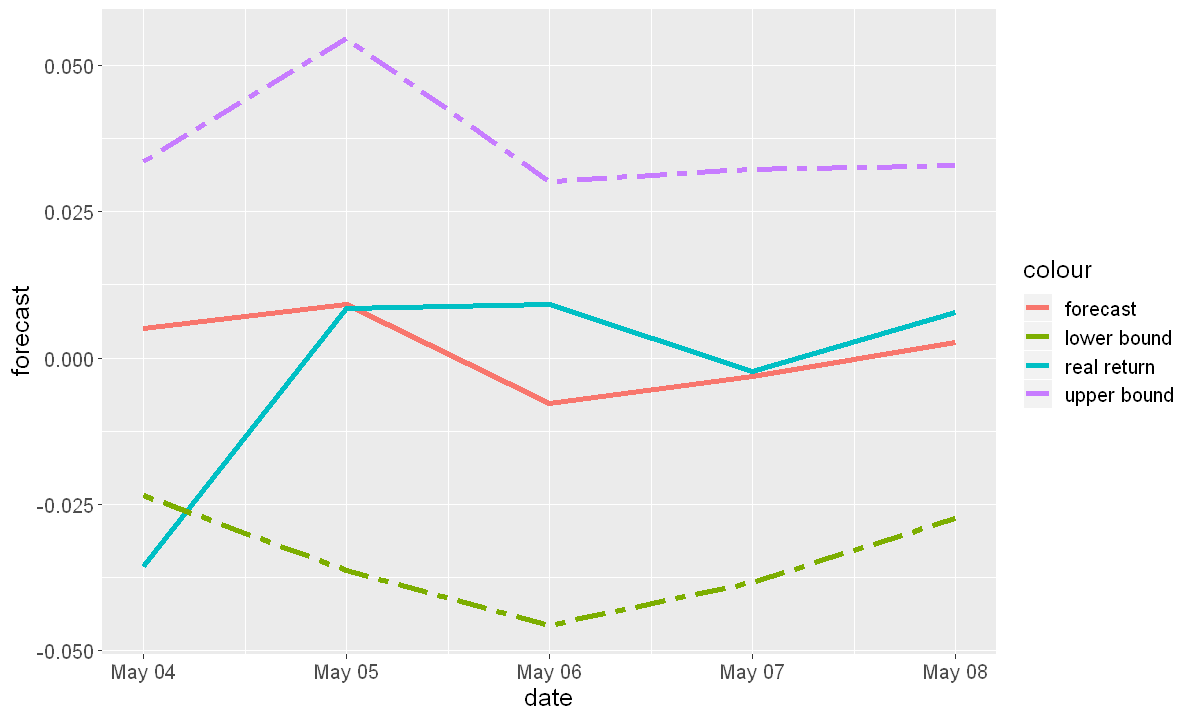

In [43]:
fig <- function(width, heigth){
     options(repr.plot.width = width, repr.plot.height = heigth)
}
# fig(10,6)
ggplot(data = df.est , aes(x=date))+
    geom_line(aes(y = forecast, color = "forecast"),lwd=1.5) +
    geom_line(aes(y = price.log.diff, color = "real return"),lwd=1.5) +
    geom_line(aes(y = lower.ci, color = "lower bound"), linetype = "twodash",lwd=1.5) +
    geom_line(aes(y = upper.ci, color = "upper bound"), linetype = "twodash",lwd=1.5) +
    theme(text = element_text(size=18)) +
    scale_size_manual( values = c(4,2,2) )